<a href="https://colab.research.google.com/github/GeorgiadouAntigoni/weak_lensing_machine_learning/blob/master/WLEmulatorAnalysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages and Prepare Environment
---



In [0]:
# Import Packages

%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt 
from glob import glob
import sys, os
from google.colab import drive
from scipy.linalg import eigh
from scipy.optimize import curve_fit


#from WLlib import WeakLensingLib as WLs

In [2]:
# Mount Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dir_project = "/content/drive/My Drive/projectWL/"
dir_code = dir_project + "codeWL/"
dir_data = dir_project + "dataWL/"

# Check what's in the directory
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/projectWL"

codeWL	dataWL


In [0]:
sys.path.append(dir_code)
#import ManifoldLearning
from ManifoldLearning import DimensionalReduction as DR


# Meta Parameters for Analysis

In [0]:
verbose = 0
case = 'lsst'


# Load Data


In [0]:
# Check/Show Data Files that exist

# These are some of the test set simulations
# each file is a simulation (ART & OWLS); used in Eifler paper for PCA (https://arxiv.org/abs/1405.7423)
# columns: zbin? , ellbin? , power spectrum magnitude , 
# These never get read in. this is to show which data sets are being used.
if verbose == 2:
  lsst = glob(dir_data + '*LSST*')

  for i in range(len(lsst)):
      print lsst[i]


In [7]:
# Load test set data

# This is the test set after tomographic analysis
# ell: angular bins
# fulldelta_all: contrast between Baryons and DM-only sims: CBaryon/CDM - 1
# columns: tomographic bin A, tomographic bin B, ell angular bin, power
fullell = np.load(dir_data + 'ell.npy')
fulldelta_all = np.load(dir_data + 'delta%s.npy'%case)

# Only picked simulations of interest and those we could reproduce
# these are hand-picked based on i) simulations of interest and ii) those that could be repduced. 
# Some of these three simulations we couldn't reproduce and some weren't ours to use
# this is used as the 'test' set
fulldelta = fulldelta_all[:,[1,2,4,5,6,7,8,9,10]]
print('fulldelta shape:', fulldelta.shape)

# Creates an array that holds all delta's from the sims
lsst_names = ['OWLS-AGN', 'ART14-CW', 'OWLS-DBLIMFV', 'OWLS-NOSN', \
              'OWLS-NOSN-NOZCOOL', 'OWLS-NOZCOOL', 'OWLS-REF', 'OWLS-WDENS', \
              'OWLS-WML1V848']

# Load training set data
# Training set data from new ART code simulations
filename_list = ["tg512_41", "tg512_42", "tg512_43", "tg512_53", "tg512_63", 
                 "tg512_73", "tg512_00", "tg512_363", "tg512_62", "tg512_72", 
                 "tg512_23", "tg512_33", "tg512_61", "tg512_22","tg512_51"]


print("lsst names:", len(lsst_names))
print("sim names:", len(filename_list))


# ========================================================
# Combine Data Sets
deltadata = []
# puts all the lsst sims in a list
for i in range(len(lsst_names)):
    deltadata.append(fulldelta[:,i])

# puts training data (new sims) into list
for i in range(len(filename_list)):
    data_temp = np.load(dir_data +"delta_" + filename_list[i] + ".npy")
    deltadata.append(data_temp)

# make it an array    
deltadata = np.array(deltadata)

# Put tags to all added simulations
names = lsst_names[:]

# descriptive labels of sim data; used for plotting
sim_names_list = ['512:[1e4,1]', '512:[1e4,2]', '512:[1e4,3]', '512:[1e5,3]', 
                  '512:[1e6,3]', '512:[1e7,3]', '512:[0,0]', '512:[3e6,3]',
                  '512:[1e6,2]', '512:[1e7,2]', '512:[1e2,3]', '512:[1e3,3]',
                  '512:[1e6,1]', '512:[1e2,2]', '512:[1e5,1]']

for name in sim_names_list:
    names.append(name)
names = np.array(names, dtype=str)

print "full data shape: ", deltadata.shape

# get ells
# All spectra are computed for five tomographic bins. There are a total
# of 5(5 + 1)/2 = 15 spectra available (five auto-spectra and ten cross-spectra).
# Each of these spectra are computed for 12 bins. 
# The length of each of the simulation vector is 15 × 12 = 180.
ell = fullell[:12]
print('ell shape', ell.shape)

('fulldelta shape:', (180, 9))
('lsst names:', 9)
('sim names:', 15)
full data shape:  (24, 180)
('ell shape', (12,))


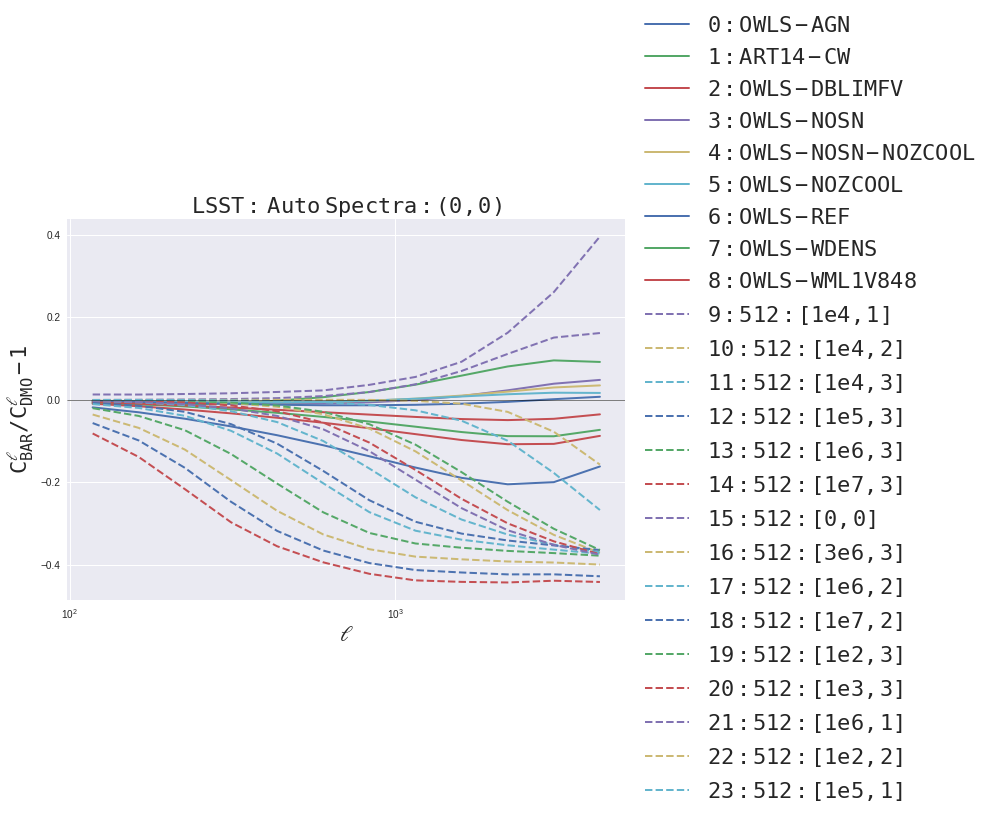

In [8]:
plt.figure(figsize=(10,7))
for i in range(len(deltadata)):
    if 'OWLS' in names[i]:
        ls='-'
    elif 'ART14' in names[i]:
        ls='-'
    elif 'HC' in names[i]:
        ls='-.'
    elif 'TG' in names[i]:
        ls=':' 
    elif '512' in names[i]:
        ls='--'
    plt.semilogx(ell, deltadata[i, :12], ls=ls, lw=2, label='$\mathtt{%i:%s}$'%(i, names[i]))
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=22)
plt.xlabel('$\mathtt{\ell}$', fontsize=22)
plt.ylabel('$\mathtt{C^{\ell}_{BAR}/C^{\ell}_{DMO}-1}$', fontsize=22)
plt.title('$\mathtt{LSST: \ Auto\ Spectra: (0,0)}$', fontsize=22)
plt.axhline(y=0, ls='-', c='k', lw=0.5)

# Prepare Training and Test Data Sets

In [0]:
# Here choose the simulations to use in the training set
# Test set fixed for the old simulations

#ind_test = [0,1,2,3,4,5,6,7,8]
#ind_train = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

#delta_train = deltadata[ind_train]
#delta_test = deltadata[ind_test]
     
#print "Training Simulations: ", names[ind_train]
#print "Testing Simulations", names[ind_test]
#print

#print delta_train.shape

In [10]:
ind_test = []
ind_train = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

delta_train = deltadata[ind_train]
delta_test = deltadata[ind_test]
     
print "Training Simulations: ", names[ind_train]
print "Testing Simulations", names[ind_test]
print

print delta_train.shape

Training Simulations:  ['OWLS-AGN' 'ART14-CW' 'OWLS-DBLIMFV' 'OWLS-NOSN' 'OWLS-NOSN-NOZCOOL'
 'OWLS-NOZCOOL' 'OWLS-REF' 'OWLS-WDENS' 'OWLS-WML1V848' '512:[1e4,1]'
 '512:[1e4,2]' '512:[1e4,3]' '512:[1e5,3]' '512:[1e6,3]' '512:[1e7,3]'
 '512:[0,0]' '512:[3e6,3]' '512:[1e6,2]' '512:[1e7,2]' '512:[1e2,3]'
 '512:[1e3,3]' '512:[1e6,1]' '512:[1e2,2]' '512:[1e5,1]']
Testing Simulations []

(24, 180)


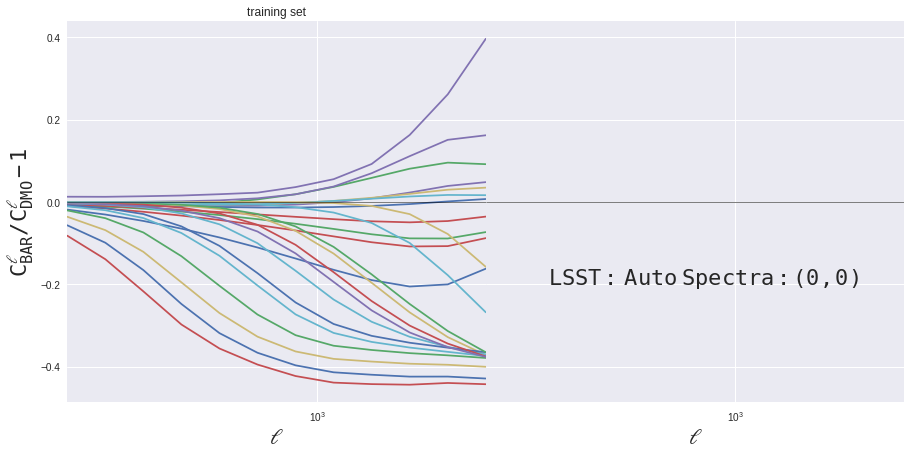

In [11]:
# plot the test and training set separately
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,7))
f.subplots_adjust(hspace=0.0, wspace=0.00)
for i in range(len(ind_train)):
    axarr[0].semilogx(ell, delta_train[i,:12])
    axarr[0].set_title("training set")
    
for i in range(len(ind_test)):
    axarr[1].semilogx(ell, delta_test[i,:12])    
    axarr[1].set_title('test set')
    
axarr[0].set_xlim(min(ell), max(ell))  
axarr[0].set_ylabel('$\mathtt{C^{\ell}_{BAR}/C^{\ell}_{DMO}-1}$', fontsize=22)
axarr[0].set_xlabel('$\mathtt{\ell}$', fontsize=22)
axarr[1].set_xlabel('$\mathtt{\ell}$', fontsize=22)
axarr[1].text(200, -0.2, '$\mathtt{LSST: \ Auto\ Spectra: (0,0)}$', fontsize=22)

axarr[0].axhline(y=0, ls='-', c='k', lw=0.5)
axarr[1].axhline(y=0, ls='-', c='k', lw=0.5)

In [12]:
max_train = delta_train.max()
max_train


0.3962526107956488

In [13]:
min_train = delta_train.min()
min_train


-0.4511219021194296

In [0]:
#max_test = delta_test.max()
#max_test

In [0]:
#min_test = delta_test.min()
#min_test

# Calculate Principle Components with SVD

In [16]:
# Truncated Singular Value Decomposition (tSVD) is a matrix factorization technique 
# that factors a matrix M into the three matrices U, Σ, and V. Similar to PCA, 
# except that the factorization for SVD is done on the data matrix, whereas for PCA,
# the factorization is done on the covariance matrix.

# choose number of principal components (PCs)
# the number of PCs is determined by the accuracy requirement of LSST
ncomp=4

# gets eigenvalues of the covariance matrix, in descending order
# only used for plotting eigenvalues for the most dominant eigenvectors
def get_ev(delta):
    cov  = np.cov(delta)
    EV,Evec = eigh(cov)
    idx = EV.argsort()[::-1]   
    EV = EV[idx]
    return EV/sum(EV)


# truncated SVD, on data matrix  
def get_pc(delta, ncomp):
    drobj = DR(delta)
    PC = drobj.TSVD(ncomp)
    return PC

# ordered eigenvalues  
ev = get_ev(np.transpose(delta_train))

# calculates principal components on the training set
pc = get_pc(np.transpose(delta_train), ncomp)

print "PCs = ", pc.shape

PCs =  (180, 4)


Text(0.5,1,'Ordered Eigenvalues')

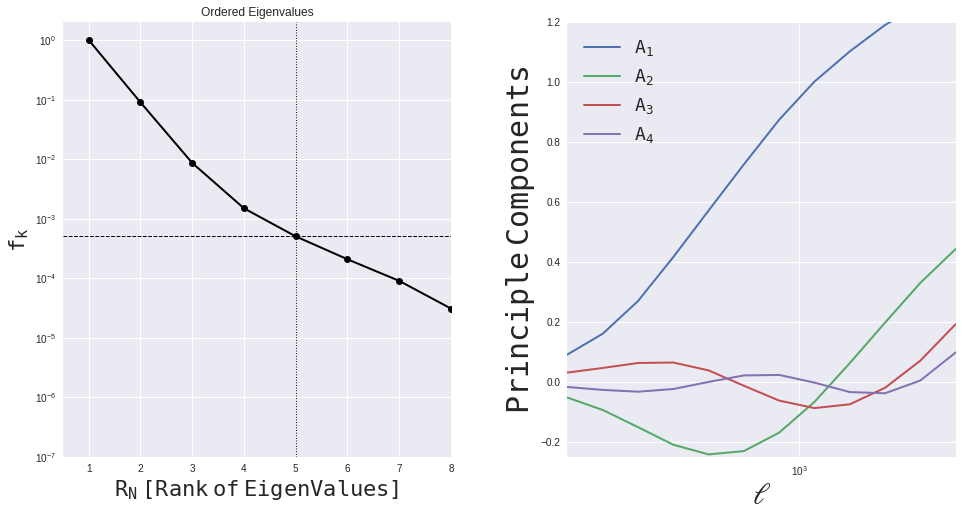

In [17]:
# plotting: eigenvalues and principle components
# diagnostic to help see how much each component contributes
f, axarr = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,8))
f.subplots_adjust(wspace=0.3,hspace=0)

# Right panel shows the 4 PCs extracted from the training sets
for i in range(pc.shape[-1]):
    axarr[1].semilogx(ell, pc[:12, i],lw=2, label='$\mathtt{A_{%i}}$'%(i+1))
axarr[1].set_xlim(min(ell), max(ell))
axarr[1].set_ylim(-0.25, 1.2)
axarr[1].set_ylabel('$\mathtt{Principle\ Components}$',fontsize=30)
axarr[1].set_xlabel('$\mathtt{\ell}$',fontsize=30)
axarr[1].legend(loc=2, fontsize=18)
axarr[1].set_title

# Left panels shows the eigenvalue fraction:
# it is the fraction of the total covariance matrix trace not accounted for by first k eigenvalues.
# The eigenvalue fraction quantifies the fractional residue left over after 
# one removes the first k (=4) eigenmodes.
yy = []
for i in range(len(ev)):
    yy.append(1-sum(ev[:i]))
y_ev = np.array(yy)
axarr[0].semilogy(range(1,len(y_ev)+1), abs(y_ev), 'ok-', lw=2)
axarr[0].axvline(x=ncomp+1, color='k', ls=':', lw=1)
axarr[0].axhline(y=y_ev[ncomp], color='k', ls='--', lw=1)

axarr[0].set_ylim(1e-7, 2)
axarr[0].set_xlim(0.5, 8)
axarr[0].set_xlabel('$\mathtt{R_N\ [Rank\ of\ EigenValues]}$', \
                    fontsize=22)
axarr[0].set_ylabel('$\mathtt{f_k}$', fontsize=22)
axarr[0].set_title('Ordered Eigenvalues')
# plt.savefig('', bbox_inches='tight', dpi=100)    

In [18]:
# fitting function is a linear combination of 4 PCs
# It finds an alternate basis for the original variables 
# with the largest variance. 
# The basis is in the form of orthogonal linear combinations
# flag: globalized variables could pose confusion, because they're global
def fittingfunc(x, a1, a2, a3, a4):
    global fullell, pc
    return a1*np.interp(x, fullell, pc[:,0]) +\
            a2*np.interp(x, fullell, pc[:,1]) +\
             a3*np.interp(x, fullell, pc[:,2]) +\
             a4*np.interp(x, fullell, pc[:,3]) # +\
            #  a5*np.interp(x, fullell, pc[:,4])

# modeling function 
def map_sim(ll, delta_ell):
  #"""fit: coefficients a1, a2, a3, a4"""
    fit, cov = curve_fit(fittingfunc, ll, delta_ell)
    fit_delta = fittingfunc(ll, *fit)
    return fit, fit_delta

# define weights 
coeff_train = []
coeff_test = []

# modelled data
# fit is the coefficients
# fit_delta is the modelled simulations (the fitted baryonic contrasts)

delta_fit_train = []
delta_fit_test = []

# fit both the training and test sets with a linear combination of the PCs
# model training data
for i in range(len(ind_train)):
    fit, fit_delta = map_sim(fullell, delta_train[i])
    coeff_train.append(fit)
    delta_fit_train.append(fit_delta)
    
# model test data
for i in range(len(ind_test)):
    fit, fit_delta = map_sim(fullell, delta_test[i])
    coeff_test.append(fit)
    delta_fit_test.append(fit_delta)
    
# check this; print(fit)

# put modelled data and weights in arrays
coeff_train = np.array(coeff_train)
coeff_test = np.array(coeff_test)
delta_fit_train = np.array(delta_fit_train)
delta_fit_test = np.array(delta_fit_test)

# calculate residuals
residue_train = np.ndarray.flatten(delta_train - delta_fit_train)
print residue_train.shape, delta_train.shape
#residue_test = np.ndarray.flatten(delta_test - delta_fit_test)
#print residue_test.shape, delta_test.shape


(4320,) (24, 180)


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


([<matplotlib.axis.XTick at 0x7f31f8a5bf90>,
 <a list of 3 Text xticklabel objects>)

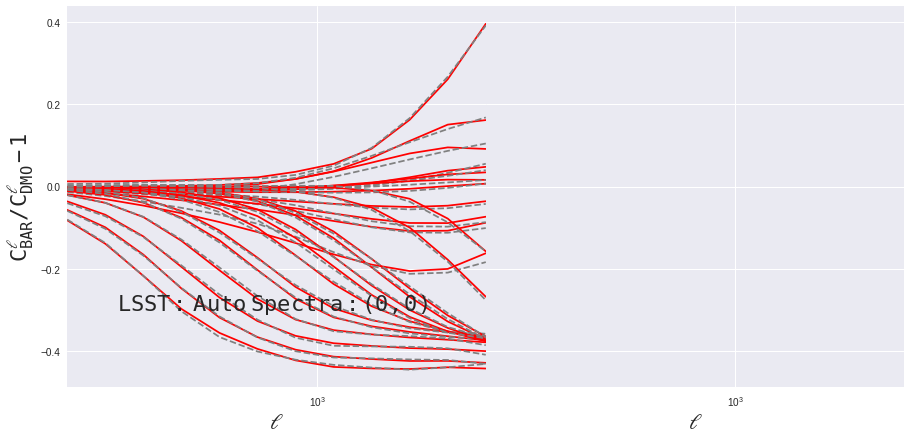

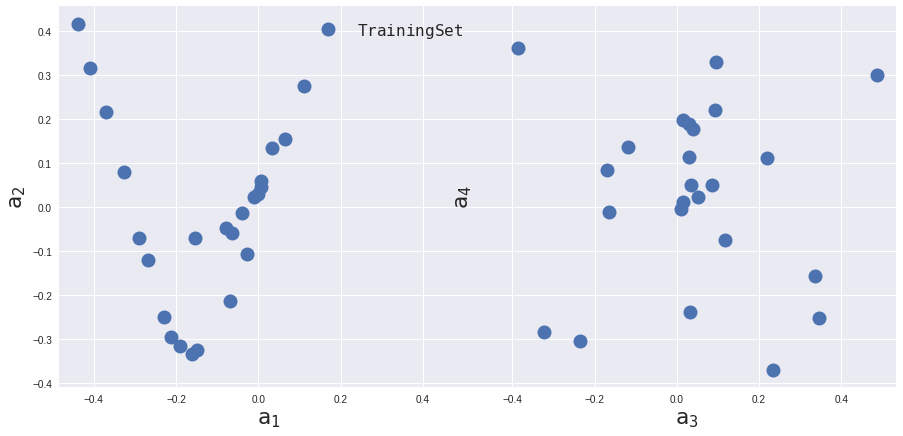

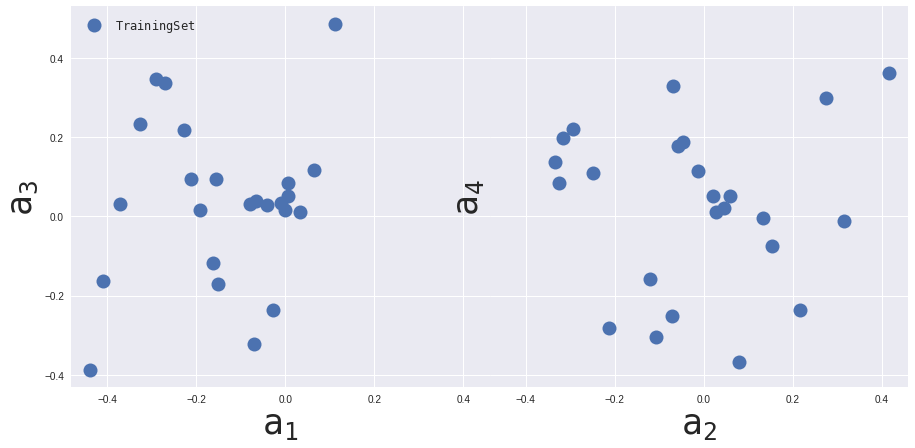

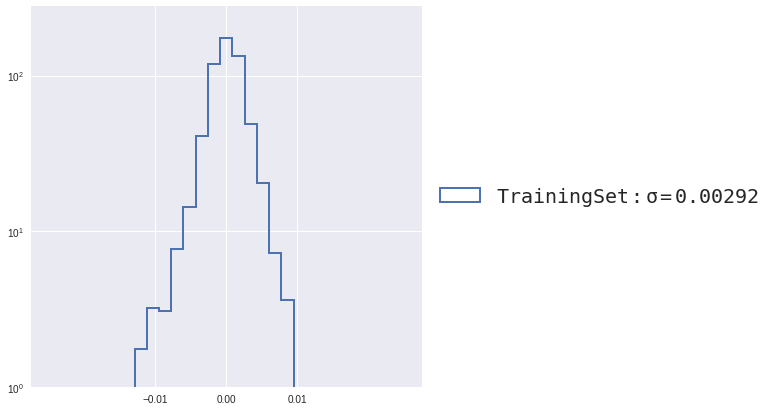

In [19]:
# Plot fits to baryon contrasts (in dashed lines) resulting from summing the first four eigenmodes
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,7))
f.subplots_adjust(hspace=0.0, wspace=0.00)

# overplot training data and modelled training data
for i in range(len(ind_train)):
    axarr[0].semilogx(ell, delta_train[i,:12],'r')
    axarr[0].semilogx(ell, delta_fit_train[i,:12], 'gray', ls='--')

# overplot test data and modelled test data
for i in range(len(ind_test)):
    axarr[1].semilogx(ell, delta_test[i,:12],'b')    
    axarr[1].semilogx(ell, delta_fit_test[i,:12], 'gray', ls='--')

axarr[0].set_xlim(min(ell), max(ell))  
axarr[0].set_ylabel('$\mathtt{C^{\ell}_{BAR}/C^{\ell}_{DMO}-1}$', fontsize=22)
axarr[0].set_xlabel('$\mathtt{\ell}$', fontsize=22)
axarr[1].set_xlabel('$\mathtt{\ell}$', fontsize=22)
axarr[1].text(5, -0.3, '$\mathtt{LSST: \ Auto\ Spectra: (0,0)}$', fontsize=22)


# plot the best fit weights/coefficients for the training and test sets
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,7))
f.subplots_adjust(hspace=0.0, wspace=0.00)
axarr[0].plot(coeff_train[:,0], coeff_train[:,1], marker='o', ms=14, ls='', label='$\mathtt{TrainingSet}$')
#axarr[0].plot(coeff_test[:,0], coeff_test[:,1], marker='s', ms=14, ls='', label='$\mathtt{TestSet}$')
axarr[1].plot(coeff_train[:,2], coeff_train[:,3], marker='o', ms=14, ls='')
#axarr[1].plot(coeff_test[:,2], coeff_test[:,3], marker='s', ms=14, ls='')
#axarr[0].set_xlim(-2,2)
#axarr[0].set_ylim(-2,2)
#axarr[1].set_xlim(-2,2)
#axarr[1].set_ylim(-2,2)
axarr[0].set_ylabel('$\mathtt{{a}_{2}}$', fontsize=22)
axarr[0].set_xlabel('$\mathtt{{a}_{1}}$', fontsize=22)
axarr[1].set_ylabel('$\mathtt{{a}_{4}}$', fontsize=22)
axarr[1].set_xlabel('$\mathtt{{a}_{3}}$', fontsize=22)
axarr[0].legend(loc=1, fontsize=16)

# should we plot the residuals as function of ell?

f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,7))
f.subplots_adjust(hspace=0.0, wspace=0.00)

axarr[0].plot(coeff_train[:,0], coeff_train[:,2], marker='o', ms=14, ls='', label='$\mathtt{TrainingSet}$')
#axarr[0].plot(coeff_test[:,0], coeff_test[:,2], marker='s', ms=14, ls='', label='$\mathtt{TestSet}$')
axarr[1].plot(coeff_train[:,1], coeff_train[:,3], marker='o', ms=14, ls='')
#axarr[1].plot(coeff_test[:,1], coeff_test[:,3], marker='s', ms=14, ls='')
#axarr[0].set_xlim(-2,2)
#axarr[0].set_ylim(-2,2)
#axarr[1].set_xlim(-2,2)
#axarr[1].set_ylim(-2,2)
axarr[0].set_ylabel('$\mathtt{{a}_{3}}$', fontsize=35)
axarr[0].set_xlabel('$\mathtt{{a}_{1}}$', fontsize=35)
axarr[1].set_ylabel('$\mathtt{{a}_{4}}$', fontsize=35)
axarr[1].set_xlabel('$\mathtt{{a}_{2}}$', fontsize=35)
axarr[0].legend(loc=2, fontsize=12)

# Distributions of rms errors for 4-PC fits to the actual 
# simulated baryonic contrasts for the fiducial case.
arr = np.linspace(-0.025, 0.025, 30)
plt.figure(figsize=(7,7))
x = plt.hist(residue_train, arr, normed=True, histtype='step', lw=2, log=True, label='$\mathtt{TrainingSet:\\sigma=%1.5f}$'%np.std(residue_train))
#x = plt.hist(residue_test, arr, normed=True, histtype='step', lw=2, log=True, label='$\mathtt{TestSet:\\sigma=%1.5f}$'%np.std(residue_test))
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.ylim(ymin=1)
plt.xticks([-0.01, 0.0, 0.01])


# do we care about how the test and training set may not overlap in coefficient space?

In [20]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


**Autoencoder Analysis**

In [37]:
# have to run this cell with the random seed function each time for reproducibility of results
# set random seeds to maintain consistency between training runs
for i in range(1,11,1):
  print i
  var_seed = i
  np.random.seed(var_seed)

PYTHONHASHSEED = 0


# set number of modes, which is the size of our encoded representations
min_dim = 2

# dimension of each simulation
orig_dim = 180
epochs = 1000 #3548
batch_size = 1

print
for i in range(1,7,1):
  print i
  alp = i

1
2
3
4
5
6
7
8
9
10

1
2
3
4
5
6


In [38]:
# set up Encoder
# activation function is the hyperbolic tangent function
input_img = Input(shape=(orig_dim,))

# encoded is the encoded representation of the input
# Using dropout regularization randomly disables some portion of neurons in a hidden layer. 
# In the Keras library, you can add dropout after any hidden layer, and you can specify
# a dropout rate, which determines the percentage of disabled neurons in the preceding layer.

# input layer/visible
encoded = Dense(alp*128, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_img)
#encoded = Dropout(0.2)(encoded)

# hidden layers
encoded = Dense(alp*16, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
#encoded = Dropout(0.2)(encoded)
encoded = Dense(min_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
#encoded = Dropout(0.2)(encoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
print "Encoder part: \n", encoder.summary()

# set up Decoder: create a placeholder for an encoded input
input_img = Input(shape=(min_dim,))

# hidden layers
decoded = Dense(alp*4, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_img)
#decoded = Dropout(0.2)(decoded)
decoded = Dense(alp*16, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(decoded)
decoded = Dropout(0.2)(decoded)


# visible layer
decoded = Dense(orig_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(decoded)
#decoded = Dropout(0.2)(decoded)

# create the decoder model
decoder = Model(input_img, decoded)
print "Decoder part: \n", decoder.summary()

# this model maps an input to its reconstruction
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
print "Full Auto-Encoder: \n", autoencoder.summary()


# configure our model to use a mse loss, and the adadelta optimizer
# update weights iterative based in training data
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['accuracy'])

minLength = 1
minBF = 5
# checkpoint: weights.best.hdf5
filename= "weights.best.alp" + str(alp) + "seed" + str(var_seed) + ".hdf5"
checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=1, save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]

Encoder part: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 180)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 768)               139008    
_________________________________________________________________
dense_8 (Dense)              (None, 96)                73824     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 194       
Total params: 213,026
Trainable params: 213,026
Non-trainable params: 0
_________________________________________________________________
None
Decoder part: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
___________________________________

In [39]:
# train our autoencoder 
history = autoencoder.fit(delta_train, delta_train, validation_split = 0.2,
                          callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1)
# verbose=1, validation_data = (delta_test, delta_test))


Train on 19 samples, validate on 5 samples
Epoch 1/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.0346 - acc: 0.0000e+00 - val_loss: 0.0171 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from inf to 0.00000, saving model to weights.best.alp6seed10.hdf5
Epoch 2/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0289 - acc: 0.0000e+00 - val_loss: 0.0146 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0126 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0204 - acc: 0.0000e+00 - val_loss: 0.0106 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0167 - acc: 0.0000e+00 - val_loss: 0.0093 - val_acc: 0.0000e+00

Epoch

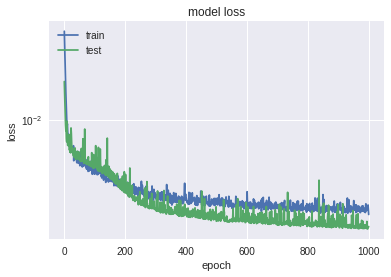

<Figure size 432x288 with 0 Axes>

In [40]:
# plot loss function progress

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()
filename= "loss.alp" + str(alp) + "seed" + str(var_seed) + ".png"
plt.savefig(filename, dpi=100)

In [0]:
# define encode & decode process
# this produces the new coefficients
def get_fit(delta):
    z = encoder.predict(delta) # predict the new kinds of coefficeints
    x = decoder.predict(z)[0] # predict the contrast (delta) from the coefficients
    return z[0], x
  

In [42]:
# setting up the data structures for autoencoded coefficients and residuals of 
# contrasts
# initialize weights and fitted data
z_train = []
z_test = []
delta_fit_vae_train = []
delta_fit_vae_test = []

# Here encodes and decodes for training data 
for i in range(len(ind_train)):
    fit, fit_delta = get_fit(np.expand_dims(delta_train[i], axis=0))
    z_train.append(fit)
    delta_fit_vae_train.append(fit_delta)
    
# Here encodes and decodes for test data
for i in range(len(ind_test)):
    fit, fit_delta = get_fit(np.expand_dims(delta_test[i], axis=0))
    z_test.append(fit)
    delta_fit_vae_test.append(fit_delta)
    
# Set weights and fitted data as arrays    
z_train = np.array(z_train)
z_test = np.array(z_test)
delta_fit_vae_train = np.array(delta_fit_vae_train)
delta_fit_vae_test = np.array(delta_fit_vae_test)

#Distributions of fitting errors (differences between dashed and solid lines)
residue_vae_train = np.ndarray.flatten(delta_train - delta_fit_vae_train)
print residue_vae_train.shape, delta_train.shape
#residue_vae_test = np.ndarray.flatten(delta_test - delta_fit_vae_test)
#print residue_vae_test.shape, delta_test.shape

(4320,) (24, 180)


([<matplotlib.axis.XTick at 0x7f31e5657350>,
 <a list of 3 Text xticklabel objects>)

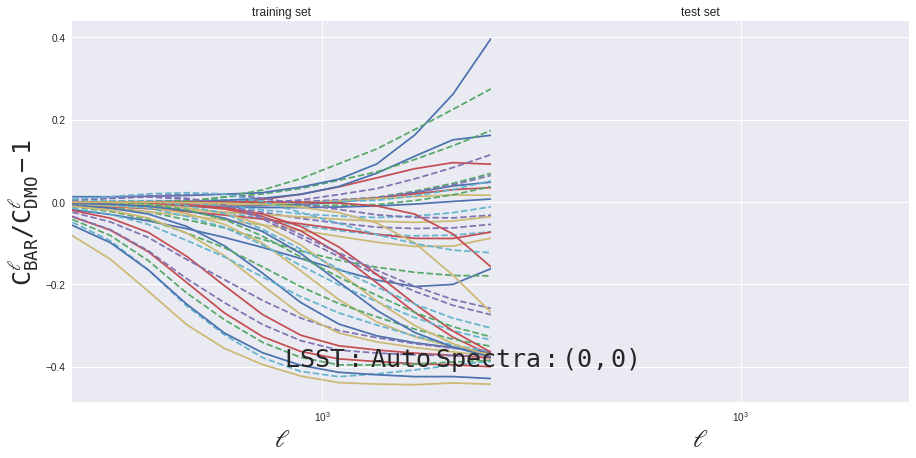

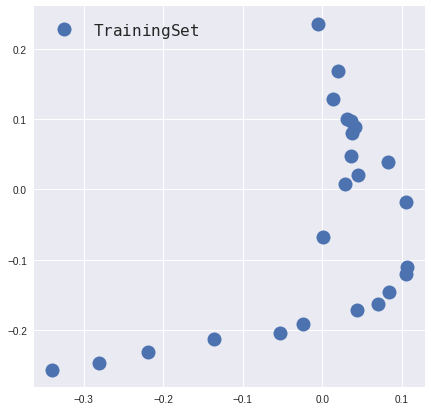

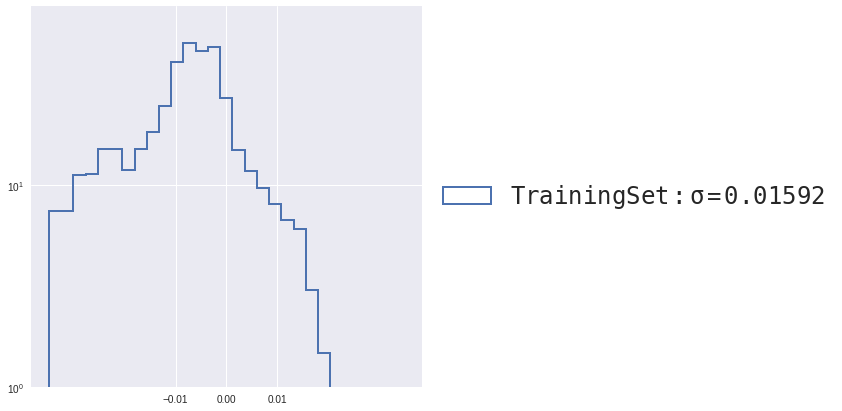

In [43]:
# Plot fits to baryon contrasts (in dashed lines) resulting from dim reduction to 2 modes
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,7))
f.subplots_adjust(hspace=0.0, wspace=0.00)

# overplot training data and modelled training data
for i in range(len(ind_train)):
    axarr[0].semilogx(ell, delta_train[i,:12])
    axarr[0].semilogx(ell, delta_fit_vae_train[i,:12], ls='--')

    
# overplot test data and modelled test data    
for i in range(len(ind_test)):
    axarr[1].semilogx(ell, delta_test[i,:12],alpha=1)    
    axarr[1].semilogx(ell, delta_fit_vae_test[i,:12], ls='--', alpha=1)

axarr[0].set_xlim(min(ell), max(ell))  
axarr[0].set_ylabel('$\mathtt{C^{\ell}_{BAR}/C^{\ell}_{DMO}-1}$', fontsize=25)
axarr[0].set_xlabel('$\mathtt{\ell}$', fontsize=25)
axarr[0].set_title('training set')
axarr[1].set_xlabel('$\mathtt{\ell}$', fontsize=25)
axarr[1].text(20, -0.4, '$\mathtt{LSST: \ Auto\ Spectra: (0,0)}$', fontsize=25)
axarr[1].set_title('test set')

#axarr[0].set_xticklabels(axarr[0].get_xticks())

# plot the best fit weights/coefficients for the training and test sets
plt.figure(figsize=(7,7))
plt.plot(z_train[:,0], z_train[:,1], marker='o', ms=14, ls='', label='$\mathtt{TrainingSet}$')
#plt.plot(z_test[:,0], z_test[:,1], marker='s', ms=14, ls='', label='$\mathtt{TestSet}$')
plt.legend(loc=0, fontsize=16)
#plt.xlim(-1,1)
#plt.ylim(-1,1)

# Distributions of rms errors for 2 modes fits to the actual 
# simulated baryonic contrasts for the fiducial case.
arr = np.linspace(-0.035, 0.035, 30)
plt.figure(figsize=(7,7))
x = plt.hist(residue_vae_train, arr, normed=True, histtype='step', lw=2, log=True, label='$\mathtt{TrainingSet: \\sigma=%1.5f}$'%np.std(residue_vae_train))
#x = plt.hist(residue_vae_test, arr, normed=True, histtype='step', lw=2, log=True, label='$\mathtt{TestSet: \\sigma=%1.5f}$'%np.std(residue_vae_test))
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24)
plt.ylim(ymin=1)
plt.xticks([-0.01, 0.0, 0.01])

# do 2,3,4 components with autoencoder

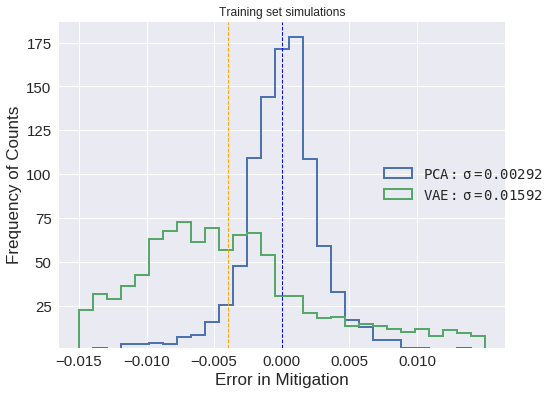

In [44]:
#Distributions of rms (the standard deviation of the residuals (prediction errors)) errors 
#for 2 (AE) and 4-PC (PCA) fits to the actual simulated 
#baryonic contrasts for the fiducial case.
#arr = np.linspace(-0.015, 0.015, 30)
#plt.figure(figsize=(8,6))
#x = plt.hist(residue_test, arr, normed=True, histtype='step', lw=2, log=False, \
#             label='$\mathtt{PCA:\ \\sigma=%1.5f}$'%np.std(residue_test))
#x = plt.hist(residue_vae_test, arr, normed=True, histtype='step', lw=2, log=False, \
#             label='$\mathtt{VAE:\ \\sigma=%1.5f}$'%np.std(residue_vae_test))
#lgd = plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.5), fontsize=14)
#plt.ylim(ymin=1)
#plt.title('Test set simulations')
##plt.xticks([-0.03, 0.0, 0.03])
#plt.xticks(np.arange(-0.015, 0.015, 0.005), fontsize =15)
#plt.yticks(fontsize =15)
#plt.xlabel('Error in Mitigation', fontsize=17)
#plt.ylabel('Frequency of Counts', fontsize=17)



#plt.axvline(x=0, color='b', linestyle='dashed', linewidth=1)

#plt.axvline(x=-0.004, color='orange', linestyle='dashed', linewidth=1)

#plt.savefig('compare_hist_pca_ae_test_2pc_1x.png', dpi=100)


#=============================
# plot for training set

arr = np.linspace(-0.015, 0.015, 30)
plt.figure(figsize=(8,6))
x = plt.hist(residue_train, arr, normed=True, histtype='step', lw=2, log=False, \
             label='$\mathtt{PCA:\ \\sigma=%1.5f}$'%np.std(residue_train))
x = plt.hist(residue_vae_train, arr, normed=True, histtype='step', lw=2, log=False, \
             label='$\mathtt{VAE:\ \\sigma=%1.5f}$'%np.std(residue_vae_train))
lgd = plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.5), fontsize=14)
plt.ylim(ymin=1)
plt.title('Training set simulations')
#plt.xticks([-0.03, 0.0, 0.03])
plt.xticks(np.arange(-0.015, 0.015, 0.005), fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel('Error in Mitigation', fontsize=17)
plt.ylabel('Frequency of Counts', fontsize=17)



plt.axvline(x=0, color='b', linestyle='dashed', linewidth=1)

plt.axvline(x=-0.004, color='orange', linestyle='dashed', linewidth=1)

filename= "PCAvsVAE.alp" + str(alp) + "seed" + str(var_seed) + ".png"
plt.savefig(filename, dpi=100)

In [45]:
#### DEPRECATED #####
# Creates an array that holds all delta's from the sims

#lsst_names = ['ART14-AD', 'OWLS-AGN', 'ART14-CW', 'ART14-CX', 'OWLS-DBLIMFV', 'OWLS-NOSN', \
#              'OWLS-NOSN-NOZCOOL', 'OWLS-NOZCOOL', 'OWLS-REF', 'OWLS-WDENS', 'OWLS-WML1V848', 'OWLS-WML4']

lsst_names = [ 'OWLS-AGN', 'ART14-CW', 'OWLS-DBLIMFV', 'OWLS-NOSN', \
              'OWLS-NOSN-NOZCOOL', 'OWLS-NOZCOOL', 'OWLS-REF', 'OWLS-WDENS', \
              'OWLS-WML1V848']

# Remove all the 2-letter ART simulations
#lsst_names = ['OWLS-AGN', 'OWLS-DBLIMFV', 'OWLS-NOSN', \
#              'OWLS-NOSN-NOZCOOL', 'OWLS-NOZCOOL', 'OWLS-REF', \
#              'OWLS-WDENS', 'OWLS-WML1V848', 'OWLS-WML4']

ell = fullell[:12]

#delta_00 = np.load('files/delta_00.npy')
#delta_01 = np.load('files/delta_01.npy')
#delta_10 = np.load('files/delta_10.npy')
#delta_11 = np.load('files/delta_11.npy')

# Creates a numpy array that holds the delta's of the TG sims
# To produce .npy files, use the main.ipynb 
# and run the WLlib on the P(k)'s from the sims
#delta_tg_00 = np.load('files/delta_tg_00.npy')
#delta_tg_10 = np.load('files/delta_tg_10.npy')
#delta_tg_13 = np.load('files/delta_tg_13.npy')
#delta_tg_43 = np.load('files/delta_tg_43.npy')
delta_tg512_41 = np.load('/content/drive/My Drive/delta_tg512_41.npy')
delta_tg512_42 = np.load('/content/drive/My Drive/delta_tg512_42.npy')
delta_tg512_43 = np.load('/content/drive/My Drive/delta_tg512_43.npy')
delta_tg512_53 = np.load('/content/drive/My Drive/delta_tg512_53.npy')
delta_tg512_63 = np.load('/content/drive/My Drive/delta_tg512_63.npy')
delta_tg512_73 = np.load('/content/drive/My Drive/delta_tg512_73.npy')
delta_tg512_00 = np.load('/content/drive/My Drive/delta_tg512_00.npy')
delta_tg512_363 = np.load('/content/drive/My Drive/delta_tg512_363.npy')
delta_tg512_62 = np.load('/content/drive/My Drive/delta_tg512_62.npy')
delta_tg512_72 = np.load('/content/drive/My Drive/delta_tg512_72.npy')
delta_tg512_23 = np.load('/content/drive/My Drive/delta_tg512_23.npy')
delta_tg512_33 = np.load('/content/drive/My Drive/delta_tg512_33.npy')

delta_tg512_61 = np.load('/content/drive/My Drive/delta_tg512_61.npy')
delta_tg512_22 = np.load('/content/drive/My Drive/delta_tg512_22.npy')
delta_tg512_51 = np.load('/content/drive/My Drive/delta_tg512_51.npy')

IOError: ignored

In [0]:
#### DEPRECATED #####

# puts all the sims in a list
deltadata = []
for i in range(len(lsst_names)):
    deltadata.append(fulldelta[:,i])

#deltadata.append(delta_00)
#deltadata.append(delta_01)
#deltadata.append(delta_10)
#deltadata.append(delta_11)

#deltadata.append(delta_tg_00)
#deltadata.append(delta_tg_10)
#deltadata.append(delta_tg_13)
#deltadata.append(delta_tg_43)
deltadata.append(delta_tg512_41)
deltadata.append(delta_tg512_42)
deltadata.append(delta_tg512_43)
deltadata.append(delta_tg512_53)
deltadata.append(delta_tg512_63)
deltadata.append(delta_tg512_73)
deltadata.append(delta_tg512_00)
deltadata.append(delta_tg512_363)
deltadata.append(delta_tg512_62)
deltadata.append(delta_tg512_72)
deltadata.append(delta_tg512_23)
deltadata.append(delta_tg512_33)

deltadata.append(delta_tg512_61)
deltadata.append(delta_tg512_22)
deltadata.append(delta_tg512_51)

deltadata = np.array(deltadata)

# Put tags to all added simulations
names = lsst_names[:]

#names.append('HC:[0,0]')
#names.append('HC:[0,1]')
#names.append('HC:[1,0]')
#names.append('HC:[1,1]')

# If you change here, change up at deltadata.append only
#names.append('TG:[0,0]')
#names.append('TG:[1e7,0]')
#names.append('TG:[1e7,3]')
#names.append('TG:[1e4,3]')
names.append('512:[1e4,1]')
names.append('512:[1e4,2]')
names.append('512:[1e4,3]')
names.append('512:[1e5,3]')
names.append('512:[1e6,3]')
names.append('512:[1e7,3]')
names.append('512:[0,0]')
names.append('512:[3e6,3]')
names.append('512:[1e6,2]')
names.append('512:[1e7,2]')
names.append('512:[1e2,3]')
names.append('512:[1e3,3]')

names.append('512:[1e6,1]')
names.append('512:[1e2,2]')
names.append('512:[1e5,1]')

names = np.array(names, dtype=str)



# Plot the delta's for all the simulation data uploaded to deltadata
# No fitting yet, just pre-processing of data
# 13 sims with 180 lenght each: if 5 bins then 5(5+1)/2= 15 spectra, then 180/15 = 12 length 
deltadata.shape

plt.figure(figsize=(15,10))
for i in range(len(deltadata)):
    if 'OWLS' in names[i]:
        ls='-'
    elif 'ART14' in names[i]:
        ls='-'
    elif 'HC' in names[i]:
        ls='-.'
    elif 'TG' in names[i]:
        ls=':' 
    elif '512' in names[i]:
        ls='--'
    plt.semilogx(ell, deltadata[i, :12], ls=ls, lw=2, label='$\mathtt{%i:%s}$'%(i, names[i]))
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=22)
plt.xlabel('$\mathtt{\ell}$', fontsize=22)
plt.ylabel('$\mathtt{C^{\ell}_{BAR}/C^{\ell}_{DMO}-1}$', fontsize=22)
plt.title('$\mathtt{LSST: \ Auto\ Spectra: (0,0)}$', fontsize=22)
plt.axhline(y=0, ls='-', c='k', lw=0.5)